In [1]:
# Import functions
import numpy as np
import matplotlib.pyplot as p
% matplotlib inline

import eigensource.add_noise as add_noise
import eigencurves
import eigenmaps
import kmeans
#import mapPCA
import bin_eigenspectra

from importlib import import_module
planet_name = 'HD189733b'
system = import_module('data.planet.{}'.format(planet_name))

looking for spidermanrc file at /home/jacob/.spidermanrc
no spidermanrc file detected


### Import spectra and generate map

In [2]:
# ...

### Generate lightcurve using STARRY

In [3]:
from gen_lightcurves import prep_map1, create_lightcurves_with_starry
lam, spaxels = prep_map1()
time, lam, dlam, lcurves = create_lightcurves_with_starry(lam, spaxels)

/home/jacob/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


[1.61154551 1.31555767 1.09258408 1.77786574 1.74683512 1.7450898
 1.88037162 2.22014106 2.85114645 3.19182404]


TypeError: (): incompatible function arguments. The following argument types are supported:
    1. (arg0: starry._starry_spectral_64.kepler.Body, arg1: float) -> None

Invoked with: <starry.kepler.Secondary(lmax=18, nwav=10, multi=False)>, array([1.61154551, 1.31555767, 1.09258408, 1.77786574, 1.74683512,
       1.7450898 , 1.88037162, 2.22014106, 2.85114645, 3.19182404])

Plot map

/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


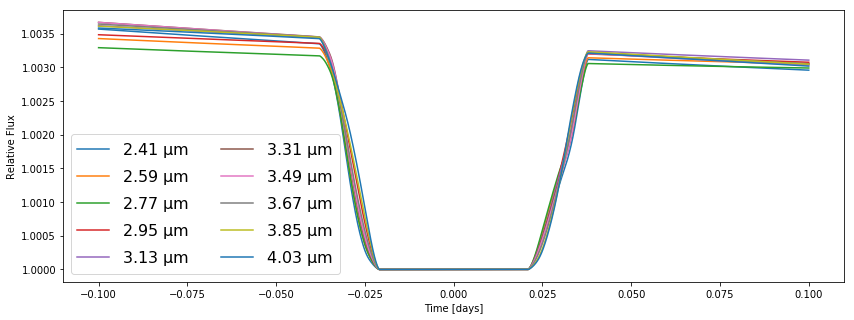

In [13]:
# Load lightcurve
stuff = np.load("data/input_lightcurves/eclipse_lightcurve_test1.npz")

# Parse File
lightcurve = stuff["lightcurve"]
wl = stuff["wl"]
dwl = stuff["dwl"]
time = stuff["time"]

# Make Plot
fig, ax = p.subplots(1, figsize=(14, 5))
ax.set_xlabel('Time [days]')
ax.set_ylabel('Relative Flux')
for i in range(len(wl)):
    lc = lightcurve[:,i] - np.min(lightcurve[:,i])
    ax.plot(time, lc+1, c = "C%i" %(i%9), label = r"%.2f $\mu$m" %(wl[i]))
ax.legend(fontsize = 16, ncol = 2)
p.show()

### Add Noise

In [14]:
inputLC3D = add_noise.get_lc()
noiseDict = add_noise.add_noise(inputLC3D)

### Fit eigencurves to lightcurve

/home/jacob/mdworlds/eigencurves.py:163: ComplexWarning: Casting complex values to real discards the imaginary part
  spheres[i] += fcoeff.T[j,2*i-1]-fcoeff.T[j,2*(i-1)]


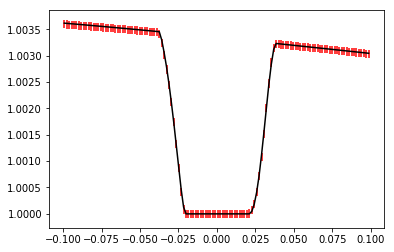

In [15]:
spherearray = eigencurves.eigencurves(noiseDict,plot=True)
# spherearray is an array of wavelength x SH coefficents

# Loop over map-draws to get errors

In [16]:
ngroups = 3
londim = 100
latdim = 100
samples = np.array([spherearray]) # output from eigencurves

eigenspectra_draws = []
kgroup_draws = []

wavelengths, lats, lons, maps = eigenmaps.generate_maps(samples, N_lon=londim, N_lat=latdim)
waves = wavelengths[0]

for draw, map_ in zip(samples, maps):
    kgroups = kmeans.kmeans(map_, ngroups)
    
    eigenspectra = bin_eigenspectra.bin_eigenspectra(map_, kgroups)
    
    eigenspectra_draws.append(eigenspectra)
    kgroup_draws.append(kgroups)

In [17]:
eigenspectra = np.mean(eigenspectra_draws, axis=0)
eigenerrs = np.std(eigenspectra_draws, axis=0)

kgroups = np.mean(kgroup_draws, axis=0)

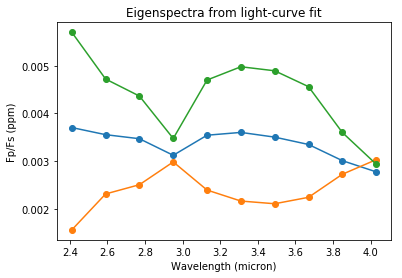

In [18]:
for spec, err in zip(eigenspectra, eigenerrs):
    p.errorbar(waves, spec, err, marker='o')
p.xlabel('Wavelength (micron)')
p.ylabel('Fp/Fs (ppm)')
p.title('Eigenspectra from light-curve fit')
p.show()

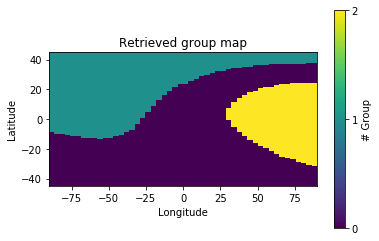

In [19]:
kgroups_day = kgroups[:,londim//4:-londim//4]
extent = np.array([np.min(lons),np.max(lons),np.min(lats),np.max(lats)])/2./np.pi*180
ax = p.imshow(kgroups_day, extent=extent)
cbar = p.colorbar(ax, ticks=np.arange(ngroups))
cbar.set_label('# Group')
p.ylabel('Latitude')
p.xlabel('Longitude')
p.title('Retrieved group map')
p.show()

/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jacob/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


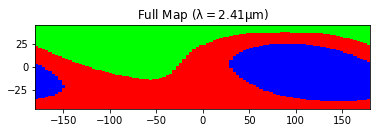

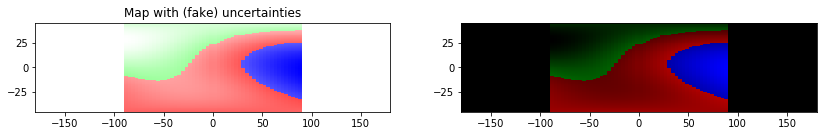

In [27]:
# Fake error example
full_extent = np.array([np.min(lons)*2,np.max(lons)*2,np.min(lats),np.max(lats)])/2./np.pi*180

map_errs = maps[0][0]
map_errs[:,-londim//4:] = np.min(map_errs)
map_errs[:,:londim//4] = np.min(map_errs)

alphas = (map_errs-np.min(map_errs)) / (np.max(map_errs)-np.min(map_errs))

# build RGBA data for 3 group case
# size (lat,lon,4)
# colour each group by R,G,B, using Alpha for errors?
X0 = np.zeros((latdim,londim,3)) # without alpha
X = np.zeros((latdim, londim, 4)) # with alpha
X[:,:,-1] = alphas
X[kgroups==0, :-1] = (1.,0,0) # first group are first colour
X[kgroups==1, :-1] = (0,1.,0)
X[kgroups==2, :-1] = (0,0,1.)
X0[kgroups==0] = (1.,0,0) # first group are first colour
X0[kgroups==1] = (0,1.,0)
X0[kgroups==2] = (0,0,1.)

p.title('Full Map ($\lambda={:.2f} \mu m$)'.format(waves[0]))
p.imshow(X0, extent=full_extent)
p.show()

p.figure(figsize=(14,6))
p.subplot(1,2,1)
p.imshow(np.ones((latdim,londim,3)), extent=full_extent) # white background
p.imshow(X, extent=full_extent) # group data
p.title('Map with (fake) uncertainties')
p.subplot(1,2,2)
p.imshow(np.zeros((latdim,londim,3)), extent=full_extent) # black background
p.imshow(X, extent=full_extent) # group data
p.show()

# Tests

### Creat a fake data set

Fake data 1, two distinct spectra

In [ ]:
lamdim = 10
latdim = 6
londim = 4
ngroups = 3

# dummy flux values
waves = np.linspace(1,2,lamdim) # micron
spec1 = np.linspace(1000,2000,lamdim) # in ppm
spec2 = np.linspace(500,600,lamdim) # in ppm
spec2[lamdim//2:-1] *= 0.5

spectra1 = [[ spec1+np.random.normal(0,100,lamdim) for _ in range(latdim) ] for __ in range(londim//2)]
spectra2 = [[ spec2+np.random.normal(0,100,lamdim) for _ in range(latdim) ] for __ in range(londim//2)]
fp_grid = np.array(spectra1+spectra2).T
print(fp_grid.shape) # should be wave, lat, lon


for lat in range(latdim):
    for lon in range(londim):
        spec = fp_grid[:,lat,lon]
        err = 100 # ppm
        p.errorbar(waves, spec, err)
p.ylabel('Fp/Fs (ppm)')
p.xlabel('Wavelength (micron)')
p.show()

Fake data 2, smoothly varying spectra

In [ ]:
fp_grid2 = np.empty((lamdim,latdim,londim))
for lat in range(latdim):
    for lon in range(londim):
        f = np.random.uniform(0,1)**2
        err = np.random.normal(0,100,lamdim)
        fp_grid2[:, lat, lon] = f*spec1 + (1-f)*spec2 + err


for lat in range(latdim):
    for lon in range(londim):
        spec = fp_grid2[:,lat,lon]
        err = 100 # ppm
        p.errorbar(waves, spec, err)
p.ylabel('Fp/Fs (ppm)')
p.xlabel('Wavelength (micron)')
p.show()

### Get groups from K-means clustering

In [ ]:
kgroups = kmeans.kmeans(fp_grid, ngroups)

kgroups2 = kmeans.kmeans(fp_grid2, ngroups)

### Create eigenspectra from K-mean clustering output

In [ ]:
eigenspectra = bin_eigenspectra.bin_eigenspectra(fp_grid, kgroups)

eigenspectra2 = bin_eigenspectra.bin_eigenspectra(fp_grid2, kgroups2)

In [ ]:
for spec in eigenspectra:
    p.plot(waves, spec)
p.title('Distinct spectra (Test 1)')
ylim = p.ylim()
p.show()

for spec in eigenspectra2:
    p.plot(waves, spec)
p.title('Smooth spectra (Test 2)')
p.ylim(ylim)
p.show()